# Taxa de Desemprego: PNAD Contínua vs. PME

Nosso objetivo nesse exercício será estender a taxa de desemprego fornecida pela Pesquisa de Nacional por Amostra de Domicílios Contínua (PNAD Contínua) através daquela fornecida pela Pesquisa Mensal de Emprego (PME). Serão construídas duas séries: uma normal, outra dessazonalizada. Faremos todo o exercício utilizando o Python.

# 1. Carregamento de Bibliotecas

In [ ]:
!pip install python-bcb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Carrega bibliotecas
import pandas as pd
from bcb import sgs
from datetime import datetime
from plotnine import *
import statsmodels.api as sm
from statsmodels.tsa import x13 # Ajuste sazonal
import os # Configuração de pastas e arquivos

# 2. Coleta e Tratamento de dados

Vamos importar os dados da taxa de desemprego da PNAD Contínua e da
PME com o código abaixo.

## 2.1 Importa série da PME

In [ ]:
# Importa arquivo .csv
pme = pd.read_csv('https://aluno.analisemacro.com.br/download/56293/?tmstv=1700150552', sep = ';', decimal = ',')

In [ ]:
pme

,Unnamed: 0,pme
0,mar/02,12.922100
1,abr/02,12.511135
2,mai/02,11.879565
3,jun/02,11.574304
4,jul/02,11.863824
...,...,...
163,out/15,7.819489
164,nov/15,7.491011
165,dez/15,6.947006
166,jan/16,7.557719


In [ ]:
# Define ponto de início
start_date = pd.to_datetime('2002-03')

# Define ponto de fim
end_date = pd.to_datetime('2016-02')

# Cria range de datas mensais
pme['Date'] = pd.date_range(start=start_date, end=end_date, freq='MS')

# Retira a coluna
pme.drop('Unnamed: 0', axis = 1, inplace = True)

# Define a data como índice
pme.set_index('Date', inplace = True)

In [ ]:
pme

,pme
Date,
2002-03-01,12.922100
2002-04-01,12.511135
2002-05-01,11.879565
2002-06-01,11.574304
2002-07-01,11.863824
...,...
2015-10-01,7.819489
2015-11-01,7.491011
2015-12-01,6.947006


## 2.2 Importa série da PNAD

In [ ]:
# Taxa de desocupação - PNADC
pnad = sgs.get({'pnad' : 24369})

In [ ]:
pnad

,pnad
Date,
2012-03-01,8.0
2012-04-01,7.8
2012-05-01,7.7
2012-06-01,7.6
2012-07-01,7.5
...,...
2023-09-01,7.7
2023-10-01,7.6
2023-11-01,7.5


## 2.3 Junta os dados

In [ ]:
# Junta os dataframe pelo índice e formato 'outer' (toda a série)
dados = pnad.join(pme, how = 'outer')
dados

,pnad,pme
Date,,
2002-03-01,NaN,12.922100
2002-04-01,NaN,12.511135
2002-05-01,NaN,11.879565
2002-06-01,NaN,11.574304
2002-07-01,NaN,11.863824
...,...,...
2023-09-01,7.7,NaN
2023-10-01,7.6,NaN
2023-11-01,7.5,NaN


Uma vez importado, você poderá verificar que a taxa de desemprego da PME vai de março de 2002 a fevereiro de 2016, enquanto a da PNAD Contínua vai de março de 2012 a setembro de 2016. Ou seja, para construírmos nossa nova série, precisamos primeiro igualar nossas séries para uma mesma amostra

In [ ]:
# Junta os dados pelo índice e formato 'inner' (somente valores comuns)
dados_2016 = pnad.join(pme, how = 'inner').reset_index()
dados_2016

,Date,pnad,pme
0,2012-03-01,8.0,6.209876
1,2012-04-01,7.8,6.049119
2,2012-05-01,7.7,5.792354
3,2012-06-01,7.6,5.859908
4,2012-07-01,7.5,5.394040
5,2012-08-01,7.4,5.315000
6,2012-09-01,7.1,5.432403
7,2012-10-01,7.0,5.326963
8,2012-11-01,6.8,4.900877
9,2012-12-01,6.9,4.630144


# 3. Visualiza as variáveis

Temos agora um conjunto de dados com a intersecção das duas séries, começando em março de 2012 e indo até fevereiro de 2016. Plotamos as duas abaixo.

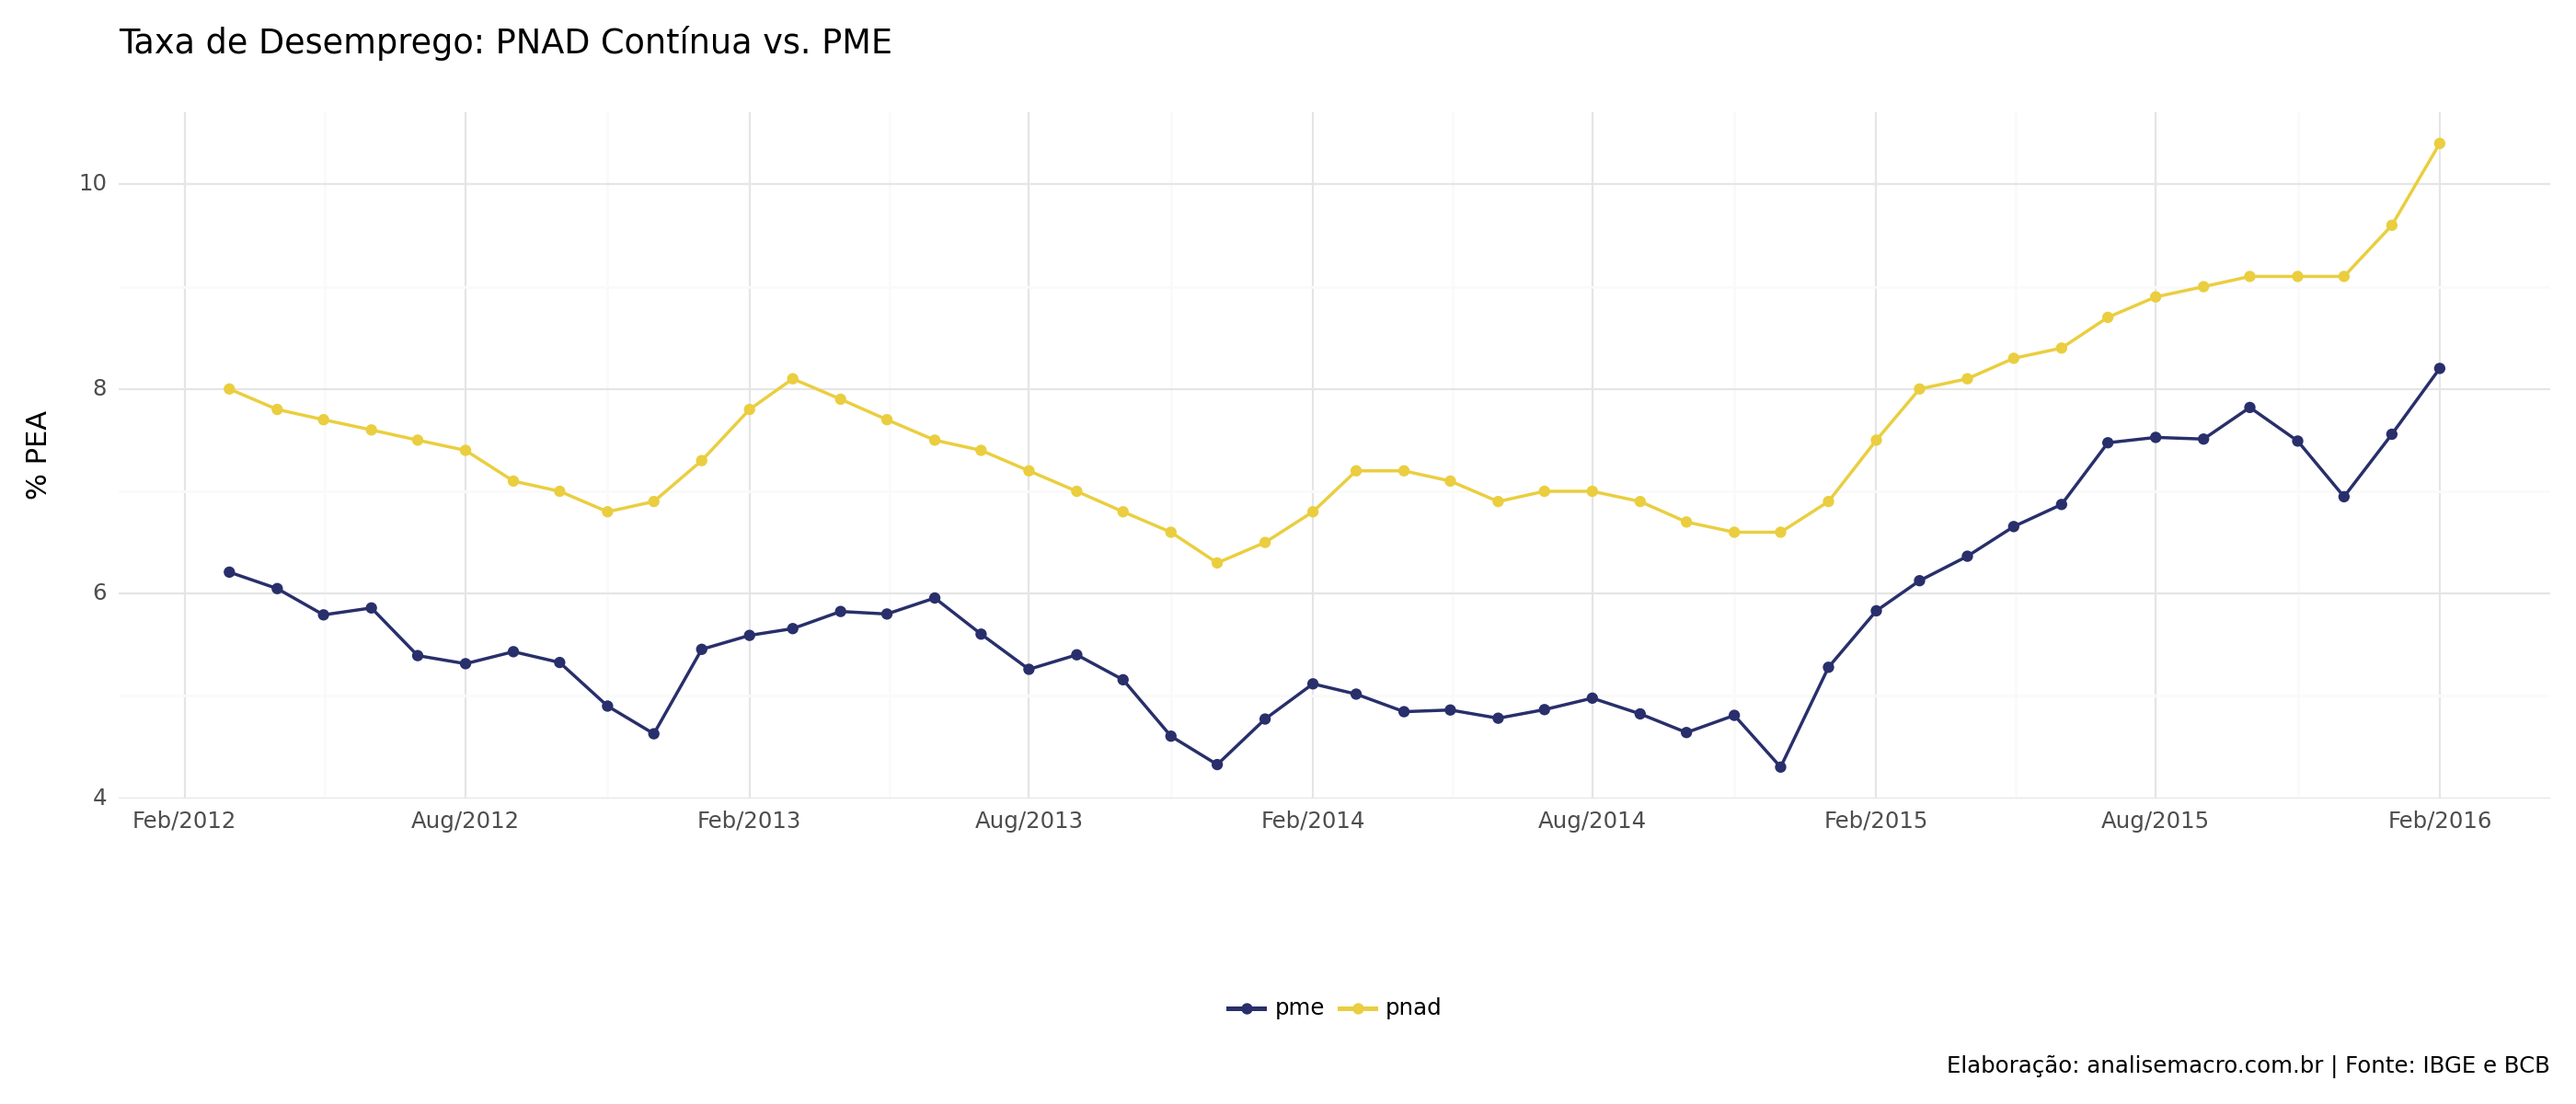

<Figure Size: (1400 x 600)>

In [ ]:
# Transforma de wide para long
dados_2016_long = dados_2016.melt(id_vars = ['Date'])

# Cores para gráficos
colors = {'blue': '#282f6b',
          'yellow': '#eace3f',
          'red'   : "#b22200",
          'green': '#224f20',
          'purple' : "#5f487c",
          'gray': '#666666',
          'orange' : '#b35c1e'
          }

# Cria o gráfico
(
 ggplot(dados_2016_long, aes(x = 'Date', y = 'value', color = 'variable')) +
 geom_line(size = 0.7) +
 geom_point() +
 scale_colour_manual(values = list(colors.values())) +
 scale_x_date(date_breaks = "6 month", date_labels = "%b/%Y") +
 labs(title = f"Taxa de Desemprego: PNAD Contínua vs. PME",
      color="",
      x="",
      y="% PEA",
      caption = "Elaboração: analisemacro.com.br | Fonte: IBGE e BCB")+
 theme_minimal() +
 theme(figure_size = (14, 6),
       legend_position = "bottom")
)

O gráfico nos mostra que a série da PNAD Contínua tem uma média maior do que a da PME, bem como é um pouco mais suave, refletindo o fato de que a mesma é uma média trimestral móvel. Ambas as séries caminham, entretanto, de forma parecida, a despeito da diferença da amostra. Abaixo as estatísticas descritivas das duas séries.

In [ ]:
# Estatísticas Descritivas
dados_2016.describe()

,Date,pnad,pme
count,48,48.000000,48.000000
mean,2014-02-14 20:00:00,7.604167,5.730090
min,2012-03-01 00:00:00,6.300000,4.304397
25%,2013-02-22 00:00:00,6.900000,4.892217
50%,2014-02-15 00:00:00,7.400000,5.443909
75%,2015-02-08 00:00:00,8.025000,6.147074
max,2016-02-01 00:00:00,10.400000,8.201058
std,NaN,0.908578,1.010961


# 4. Exercício: Ampliando a série da PNAD

Uma vez definido o conjunto de dados, passemos ao exercício em si. Como o nosso objetivo é basicamente expandir a taxa de desemprego da PNAD Contínua, vamos então regredir a mesma contra a taxa da PME.

## 4.1 Regressão Linear

In [ ]:
# Ajustar o modelo de regressão usando from_formula
formula = 'pnad ~ pme'
reg = sm.OLS.from_formula(formula, data=dados_2016).fit()

In [ ]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   pnad   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     565.2
Date:                Mon, 06 May 2024   Prob (F-statistic):           1.76e-27
Time:                        15:38:57   Log-Likelihood:               -0.92070
No. Observations:                  48   AIC:                             5.841
Df Residuals:                      46   BIC:                             9.584
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6520      0.211     12.541      0.0

In [ ]:
# Criar DataFrame com séries temporais do modelo e dos dados originais
modelo = pd.DataFrame({'Desemprego PNAD Contínua': dados_2016['pnad'], 'Modelo': reg.fittedvalues, 'Date' : dados_2016['Date']})
modelo.head()

,Desemprego PNAD Contínua,Modelo,Date
0,8.0,8.018819,2012-03-01
1,7.8,7.879886,2012-04-01
2,7.7,7.657978,2012-05-01
3,7.6,7.716362,2012-06-01
4,7.5,7.313738,2012-07-01


### 4.1.1 Valores Ajustados da PNAD pelo Modelo

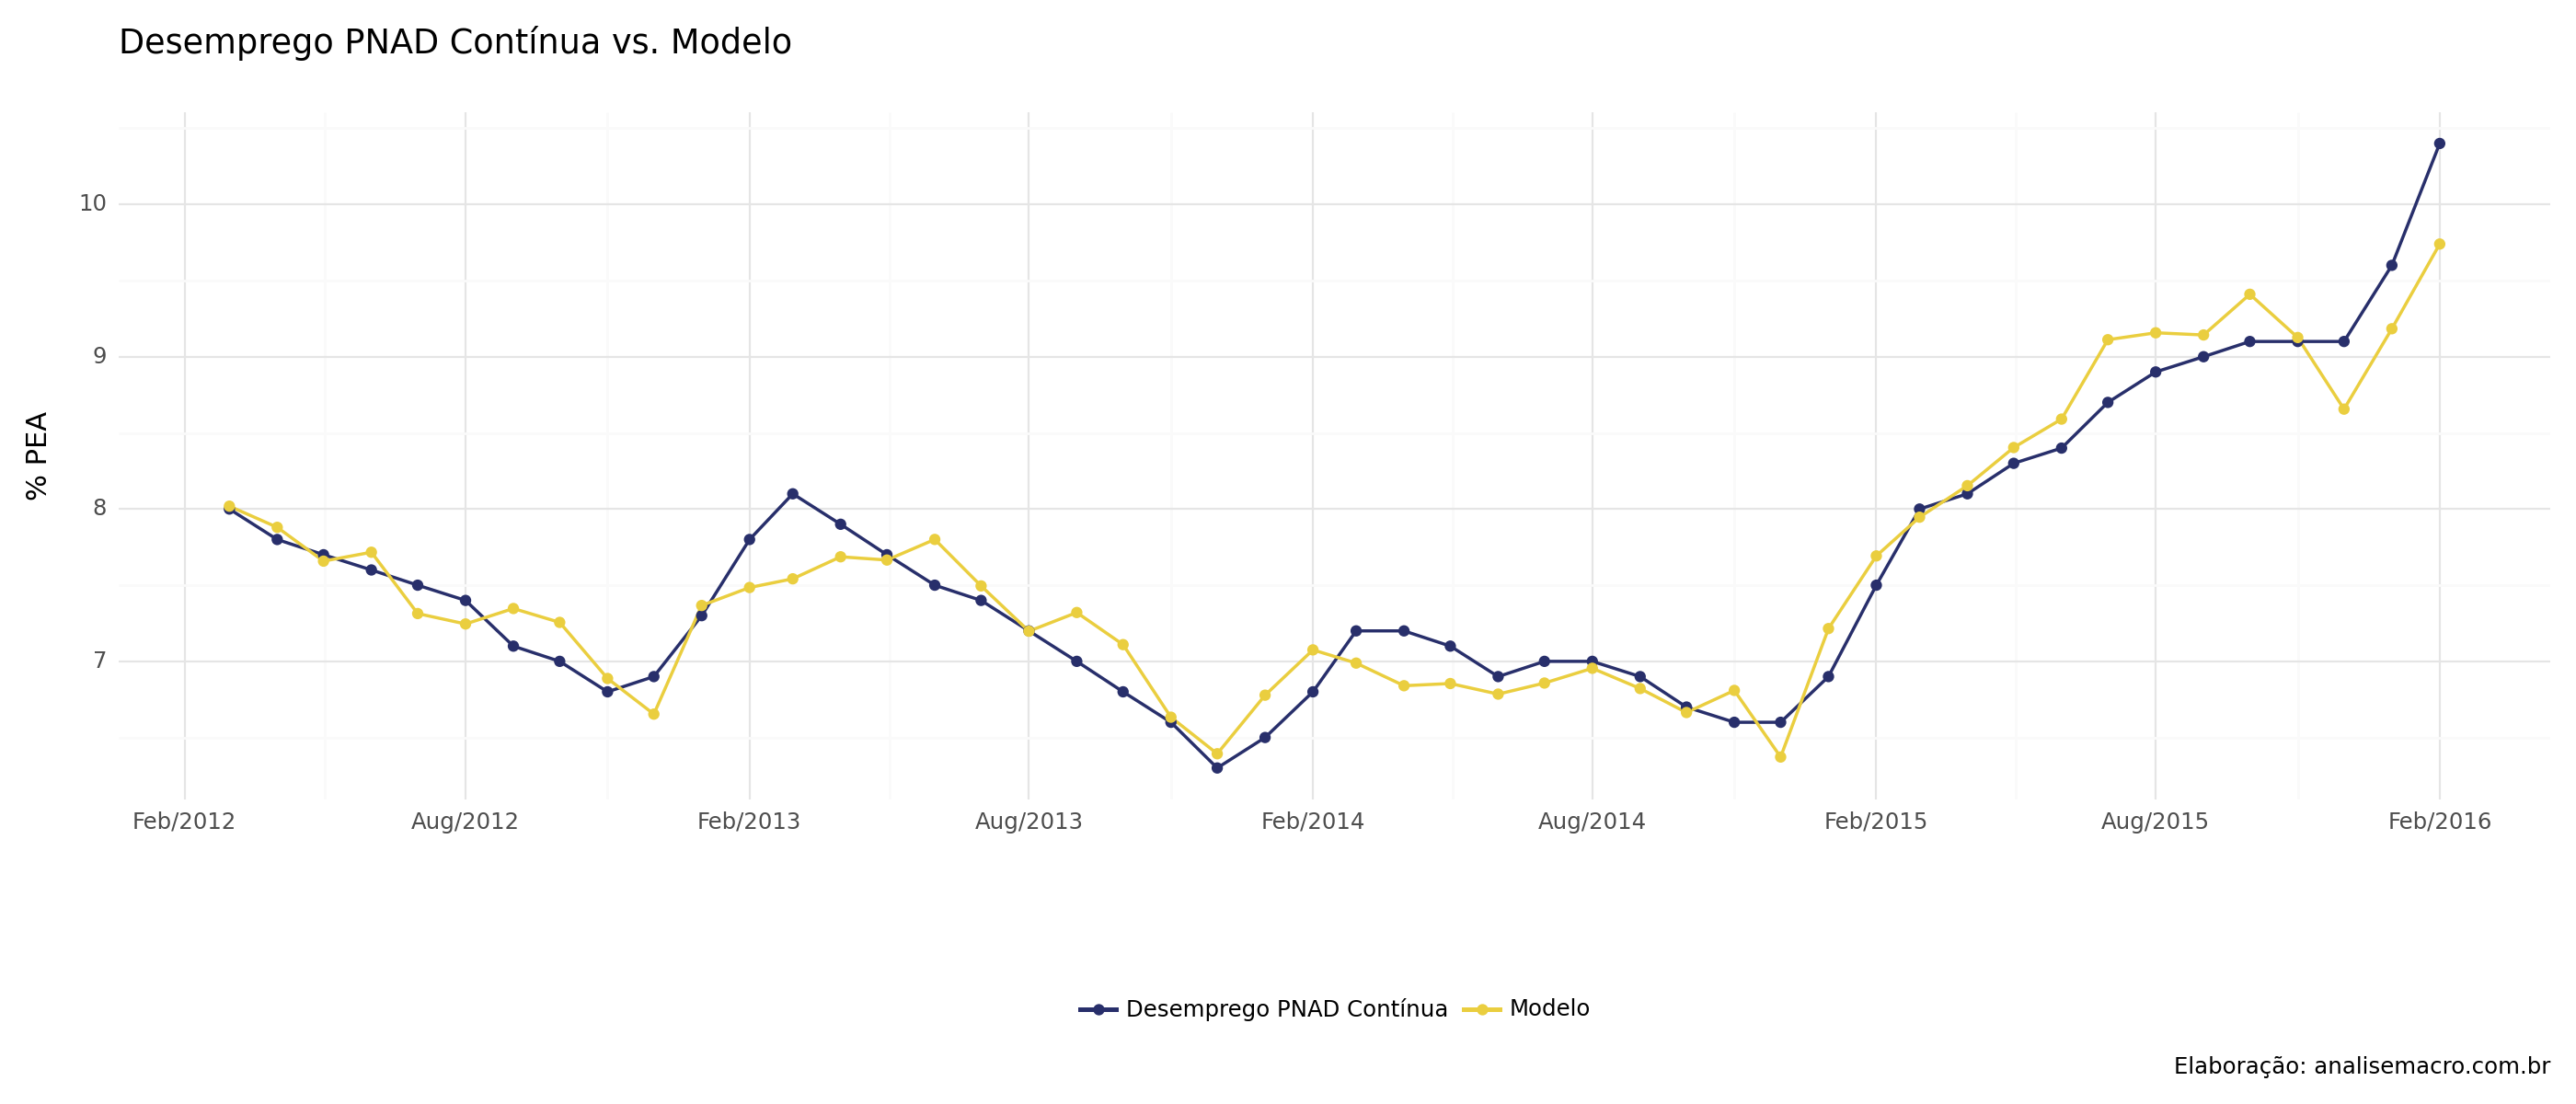

<Figure Size: (1400 x 600)>

In [ ]:
# Transforma de wide para long
modelo_long = modelo.melt(id_vars = ['Date'])

# Cria o gráfico
(
 ggplot(modelo_long, aes(x = 'Date', y = 'value', color = 'variable')) +
 geom_line(size = 0.7) +
 geom_point() +
 scale_colour_manual(values = list(colors.values())) +
 scale_x_date(date_breaks = "6 month", date_labels = "%b/%Y") +
 labs(title = f"Desemprego PNAD Contínua vs. Modelo",
      color="",
      x="",
      y="% PEA",
      caption = "Elaboração: analisemacro.com.br")+
 theme_minimal() +
 theme(figure_size = (14, 6),
       legend_position = "bottom")
)

### 4.1.2 Valores Ampliados da PNAD

In [ ]:
# Criar Série PNAD Contínua Ampliada
pnad_pme = dados[~dados['pnad'].notna()].copy()
pnad_pme['pnad'] = reg.params.Intercept + reg.params.pme * pnad_pme['pme']
pnad_pme

,pnad,pme
Date,,
2002-03-01,13.819814,12.922100
2002-04-01,13.464640,12.511135
2002-05-01,12.918810,11.879565
2002-06-01,12.654990,11.574304
2002-07-01,12.905206,11.863824
...,...,...
2011-10-01,7.609514,5.736277
2011-11-01,7.130463,5.181976
2011-12-01,6.743548,4.734284


In [ ]:
# Concatena os dados
pnad_ampliada = pd.concat([pnad_pme[['pnad']], dados[['pnad']].dropna()])

In [ ]:
pnad_ampliada

,pnad
Date,
2002-03-01,13.819814
2002-04-01,13.464640
2002-05-01,12.918810
2002-06-01,12.654990
2002-07-01,12.905206
...,...
2023-09-01,7.700000
2023-10-01,7.600000
2023-11-01,7.500000


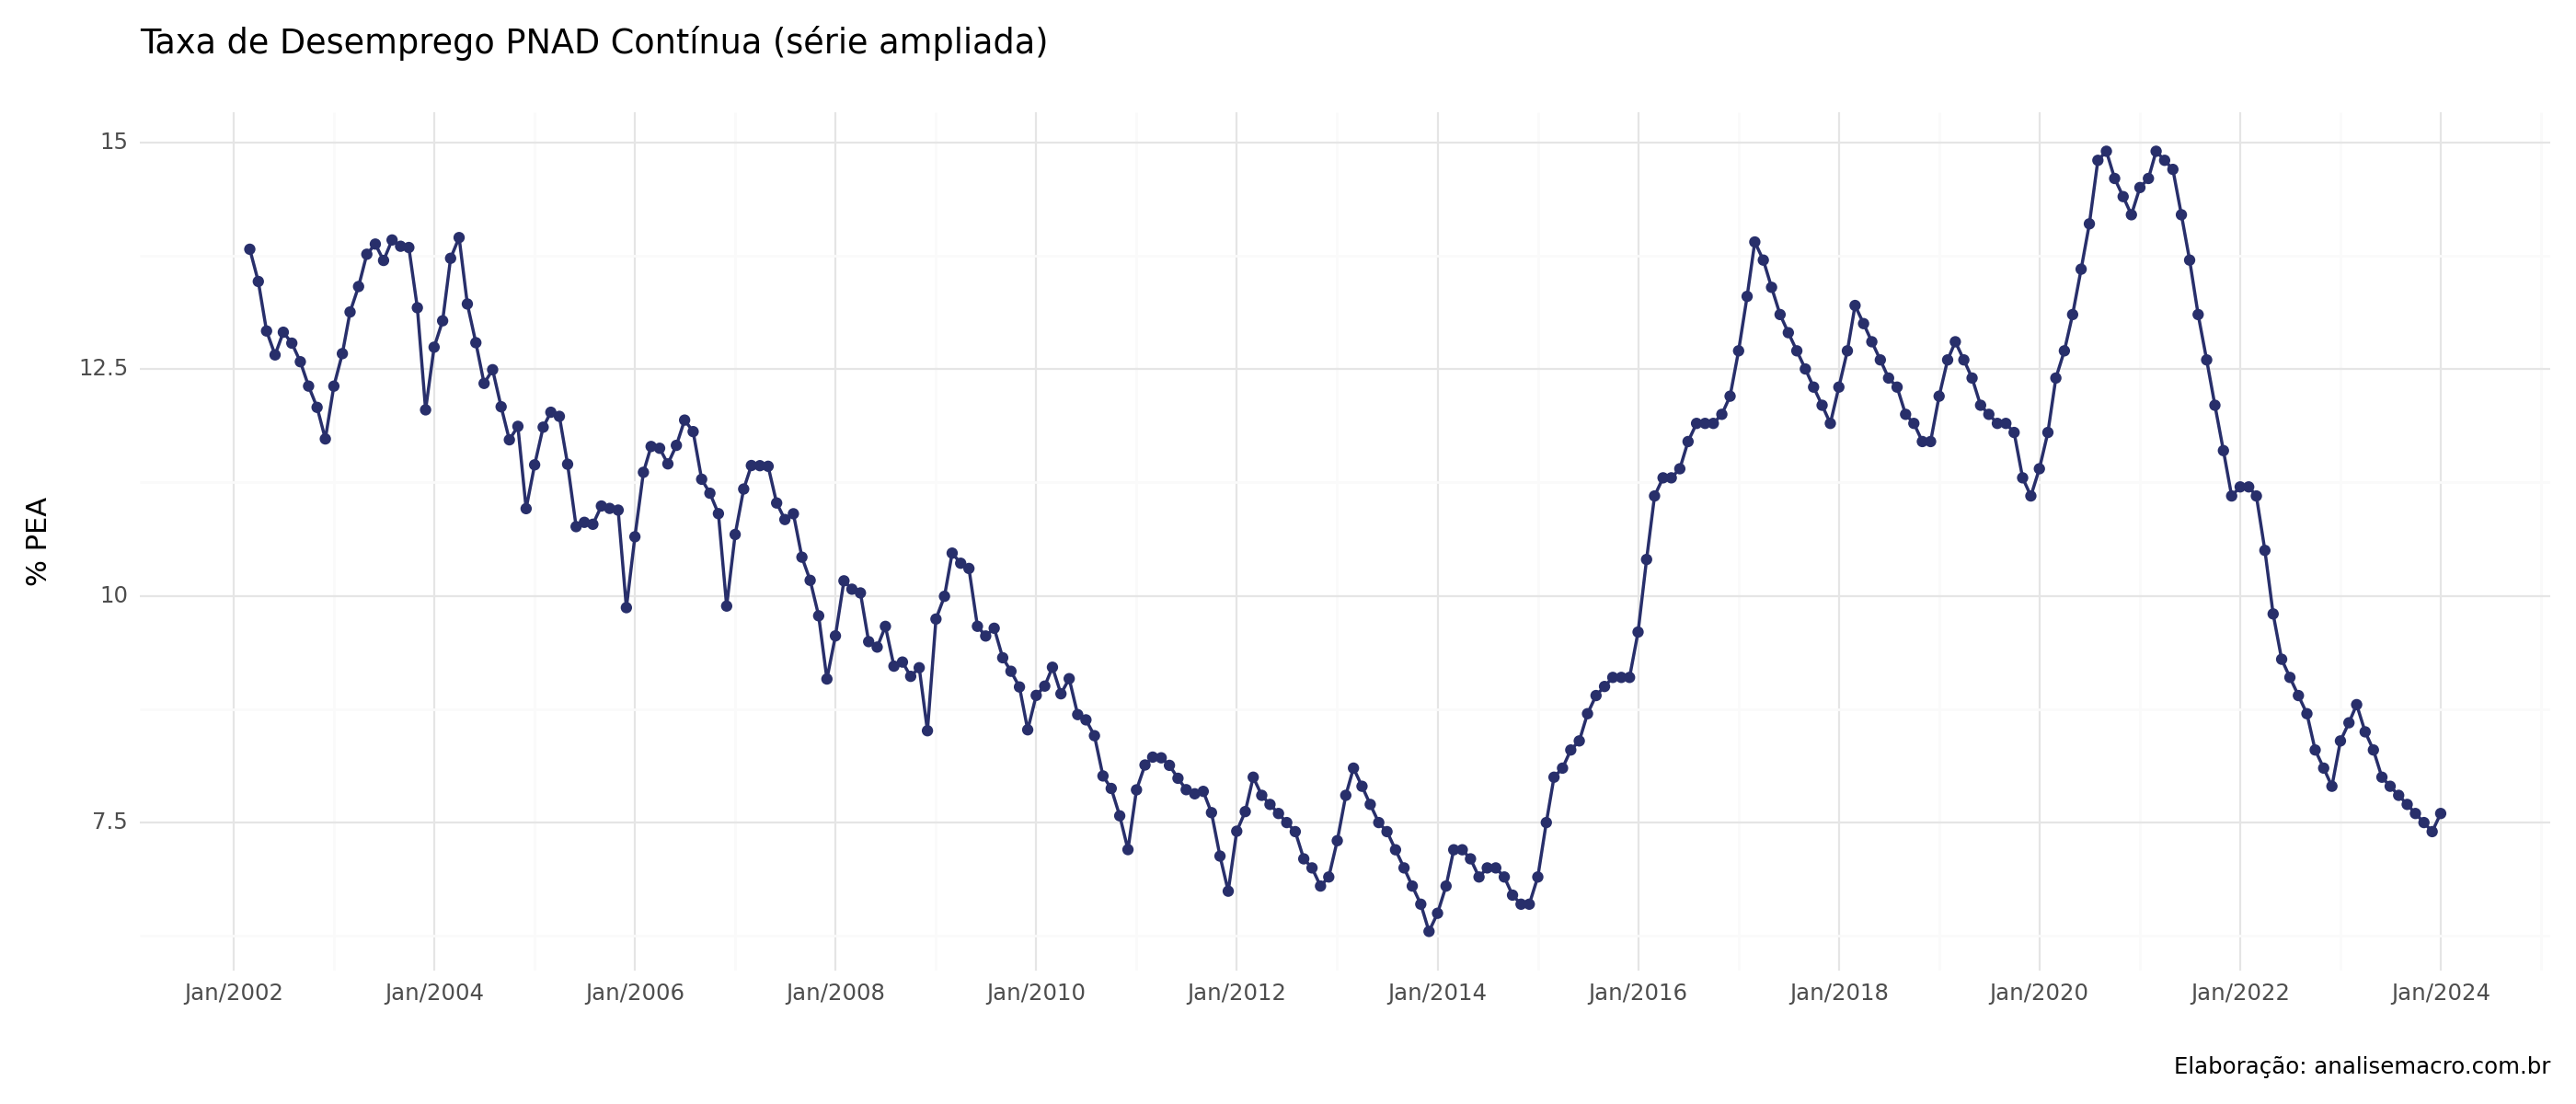

<Figure Size: (1400 x 600)>

In [ ]:
# Cria o gráfico
(
 ggplot(pnad_ampliada.reset_index(), aes(x = 'Date', y = 'pnad')) +
 geom_line(size = 0.7, color = '#282f6b') +
 geom_point(color = '#282f6b') +
 scale_x_date(date_breaks = "2 years", date_labels = "%b/%Y") +
 labs(title = f"Taxa de Desemprego PNAD Contínua (série ampliada)",
      color="",
      x="",
      y="% PEA",
      caption = "Elaboração: analisemacro.com.br")+
 theme_minimal() +
 theme(figure_size = (14, 6))
)

# 5. Dessazonalização

Podemos, agora, dessazonalizar a nossa taxa de desemprego.

In [ ]:
# O método abaixo aplica para o Google Colab. Para outras IDEs, verificar o sistema operacional
# Baixa e descompacta o X13-ARIMA-SEATS (veja mais info em: https://www.census.gov/data/software/x13as.X-13ARIMA-SEATS.html)
!wget https://www2.census.gov/software/x-13arima-seats/x13as/unix-linux/program-archives/x13as_ascii-v1-1-b59.tar.gz
!tar --gunzip --extract --verbose --file=x13as_ascii-v1-1-b59.tar.gz
# Define o caminho do programa como variável de ambiente
os.environ["X13PATH"] = "x13as"

--2024-05-06 15:39:01--  https://www2.census.gov/software/x-13arima-seats/x13as/unix-linux/program-archives/x13as_ascii-v1-1-b59.tar.gz
Resolving www2.census.gov (www2.census.gov)... 23.56.117.120, 2600:1406:40:196::208c, 2600:1406:40:19f::208c
Connecting to www2.census.gov (www2.census.gov)|23.56.117.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3780035 (3.6M) [application/x-tar]
Saving to: ‘x13as_ascii-v1-1-b59.tar.gz’

x13as_ascii-v1-1-b5 100%[===================>]   3.60M  --.-KB/s    in 0.1s    

2024-05-06 15:39:01 (25.6 MB/s) - ‘x13as_ascii-v1-1-b59.tar.gz’ saved [3780035/3780035]

x13as/
x13as/docs/
x13as/docs/docx13as.pdf
x13as/docs/qrefX13ASunix.pdf
x13as/testairline.spc
x13as/x13as_ascii


In [ ]:
pnad_ampliada

,pnad
Date,
2002-03-01,13.819814
2002-04-01,13.464640
2002-05-01,12.918810
2002-06-01,12.654990
2002-07-01,12.905206
...,...
2023-09-01,7.700000
2023-10-01,7.600000
2023-11-01,7.500000


In [ ]:
# Ajusta sazonalmente a pnad
pnad_ampliada = (
    pnad_ampliada
    .assign(pnad_ampliada_sa = lambda x: x13.x13_arima_analysis(endog = x.pnad).seasadj)
    .reset_index()
)

pnad_ampliada

,Date,pnad,pnad_ampliada_sa
0,2002-03-01,13.819814,13.260005
1,2002-04-01,13.464640,12.814436
2,2002-05-01,12.918810,12.529486
3,2002-06-01,12.654990,12.499258
4,2002-07-01,12.905206,12.867762
...,...,...,...
258,2023-09-01,7.700000,7.803439
259,2023-10-01,7.600000,7.827837
260,2023-11-01,7.500000,7.808730
261,2023-12-01,7.400000,7.786683


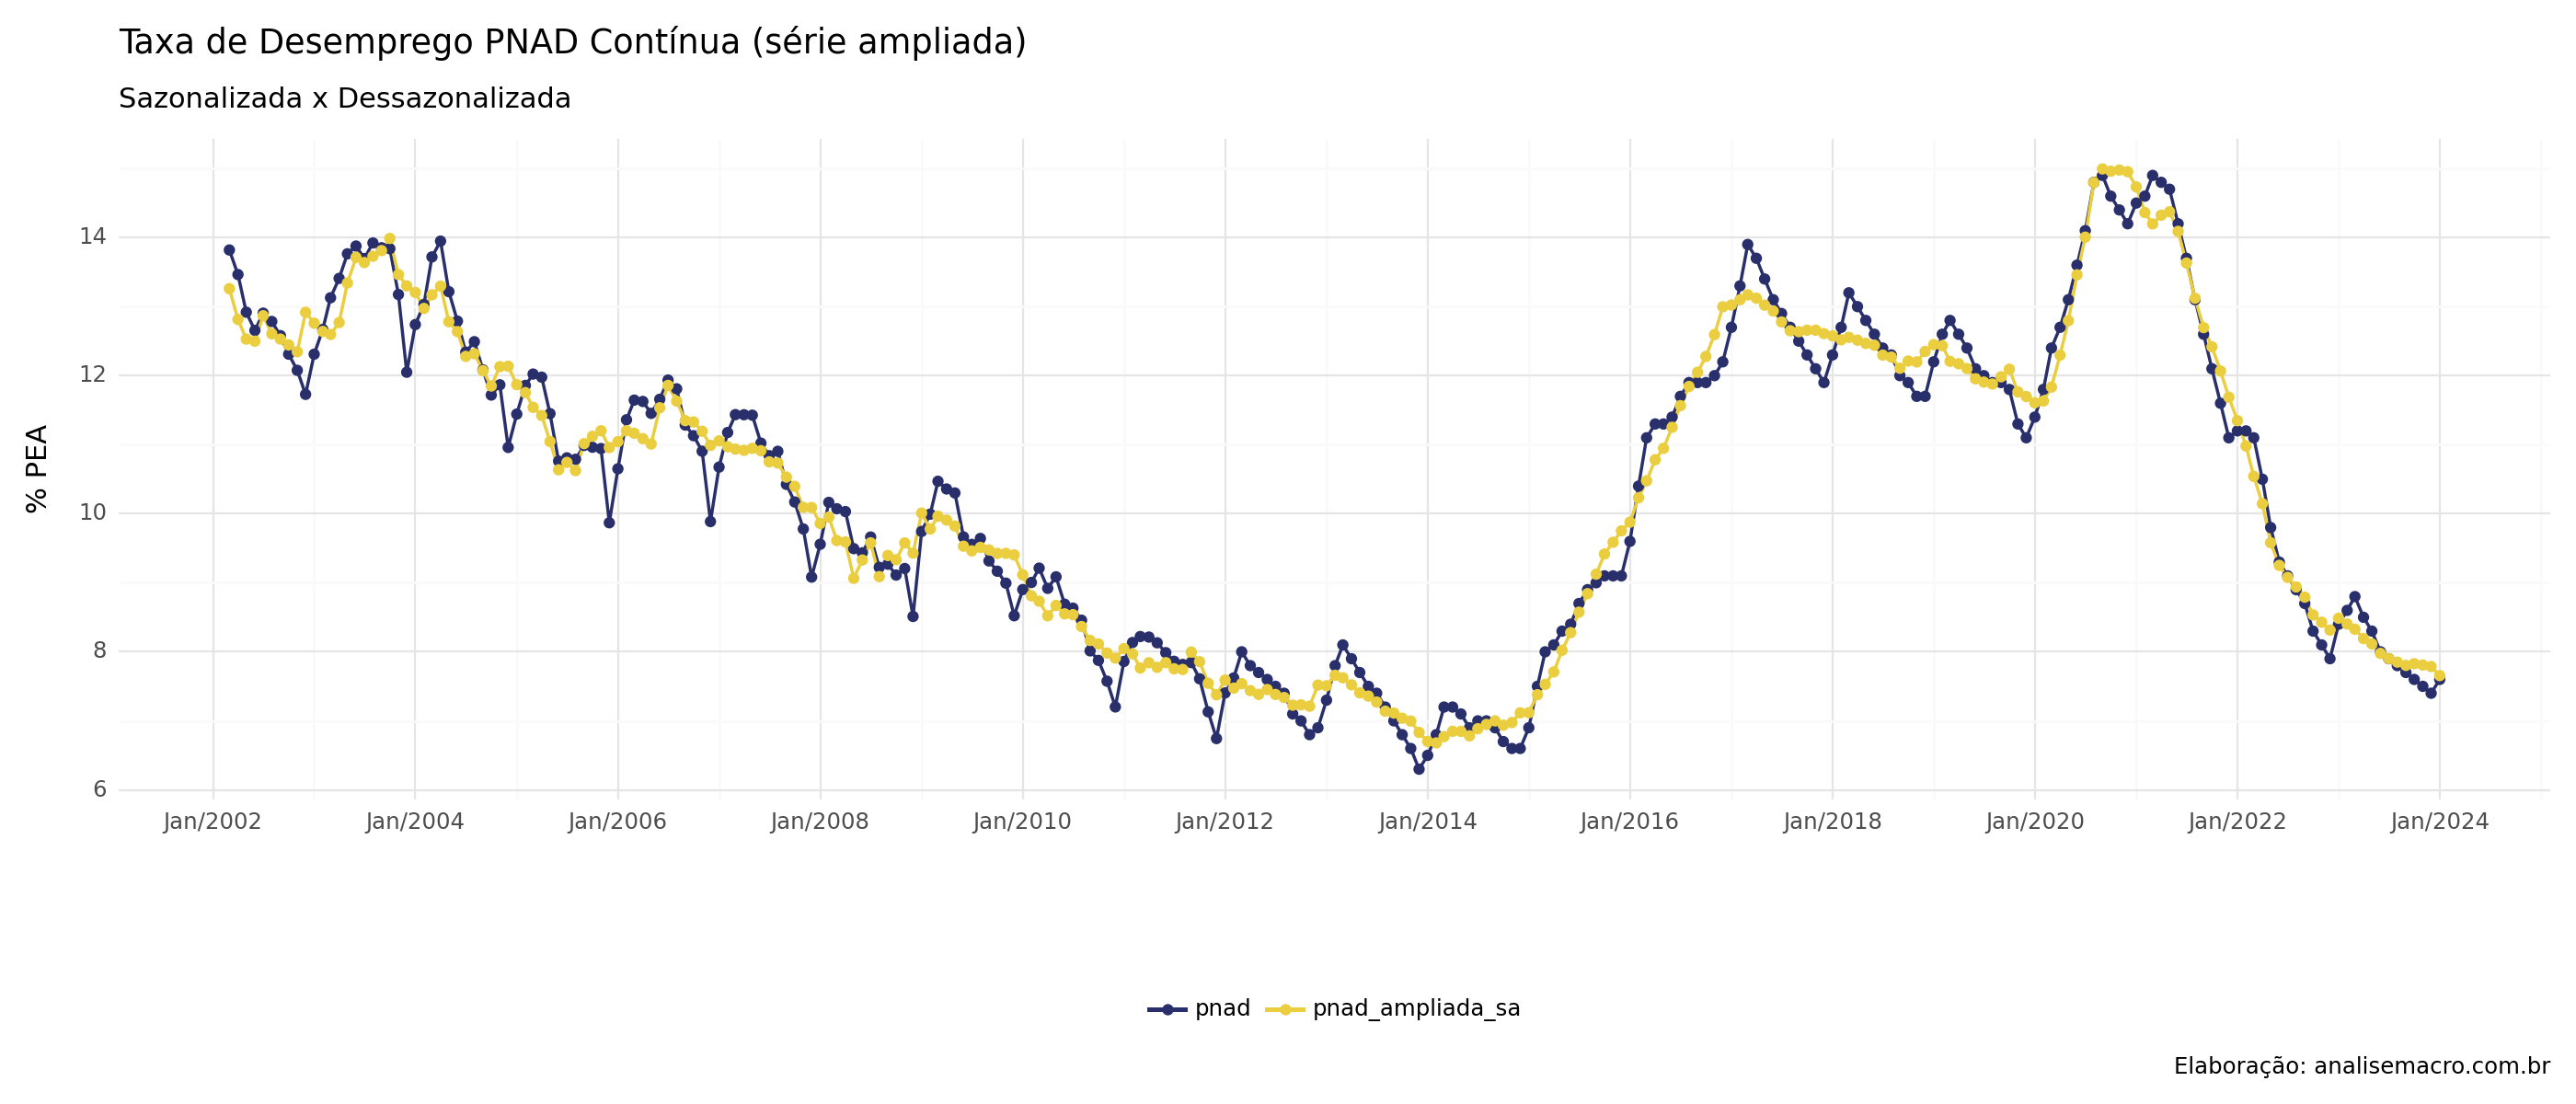

<Figure Size: (1400 x 600)>

In [ ]:
# Transforma de wide para long
pnad_ampliada_long = pnad_ampliada.melt(id_vars = ['Date'])

# Cria o gráfico
(
 ggplot(pnad_ampliada_long, aes(x = 'Date', y = 'value', color = 'variable')) +
 geom_line(size = 0.7) +
 geom_point() +
 scale_colour_manual(values = list(colors.values())) +
 scale_x_date(date_breaks = "2 years", date_labels = "%b/%Y") +
 labs(title = f"Taxa de Desemprego PNAD Contínua (série ampliada)",
      subtitle = 'Sazonalizada x Dessazonalizada',
      color="",
      x="",
      y="% PEA",
      caption = "Elaboração: analisemacro.com.br")+
 theme_minimal() +
 theme(figure_size = (14, 6),
       legend_position = "bottom")
)